In [1]:
%load_ext autoreload
%autoreload 2

# Dev script for calculating gradients in ECCO using xgcm

In [33]:
import numpy as np
import xarray as xr
from xgcm import Grid
import glob
import matplotlib.pyplot as plt

In [48]:
rootdir = '/data2/project/ECCO4v4/'

In [81]:
# shortwave
localdir = 'nctiles_monthly/MXLDEPTH/*/'
filename = 'MXLDEPTH_*.nc'
Q = xr.open_mfdataset(rootdir+localdir+filename)
Q = Q.rename({'tile':'face'}).drop(['XC','YC','timestep','time_bnds'])

In [82]:
# rootdir = '/home/gmacgilchrist/data/ECCO/'
# filename = 'ECCO-GRID.nc'
# grid = xr.open_dataset(rootdir+filename)
# grid
def preprocess(ds):
    dsnew = ds.copy()
    dsnew = dsnew.expand_dims({'face':[int(ds.encoding["source"][41:45])]})
    return dsnew
localdir = 'nctiles_grid/'
filename = 'GRID.*.nc'
grid = xr.open_mfdataset(rootdir+localdir+filename, preprocess=preprocess)
grid = grid.rename({'i1':'k','i2':'j','i3':'i'})
grid

<xarray.Dataset>
Dimensions:  (face: 13, i: 90, j: 90, k: 50)
Coordinates:
  * face     (face) int64 1 2 3 4 5 6 7 8 9 10 11 12 13
  * k        (k) float64 1.0 2.0 3.0 4.0 5.0 6.0 ... 46.0 47.0 48.0 49.0 50.0
  * j        (j) float64 1.0 2.0 3.0 4.0 5.0 6.0 ... 86.0 87.0 88.0 89.0 90.0
  * i        (i) float64 1.0 2.0 3.0 4.0 5.0 6.0 ... 86.0 87.0 88.0 89.0 90.0
Data variables:
    hFacC    (face, k, j, i) float64 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    hFacW    (face, k, j, i) float64 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    hFacS    (face, k, j, i) float64 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    XC       (face, j, i) float64 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    YC       (face, j, i) float64 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    XG       (face, j, i) float64 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    YG       (face, j, i) float64 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    RAC      (face, j, i) float64 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    RAZ      (face, j, i) float64 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    DXC      (face, j, i) float64 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    DYC      (face, j, i) float64 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    DXG      (face, j, i) float64 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    DYG      (face, j, i) float64 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    Depth    (face, j, i) float64 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    AngleCS  (face, j, i) float64 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    AngleSN  (face, j, i) float64 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    RC       (face, k) float64 dask.array<chunksize=(1, 50), meta=np.ndarray>
    RF       (face, k) float64 dask.array<chunksize=(1, 50), meta=np.ndarray>
    DRC      (face, k) float64 dask.array<chunksize=(1, 50), meta=np.ndarray>
    DRF      (face, k) float64 dask.array<chunksize=(1, 50), meta=np.ndarray>
Attributes:
    description:    C-grid parameters (see MITgcm documentation for details)....
    A:              estimate source : Gael Forget, MIT/AER/JPL ECCO-Productio...
    B:              support contact : ecco@ocean.mit.edu
    C:              
    D:              internal code : r4it11
    E:              estimate revision history :
    F:                 r4it11   : reduce background vertical viscosity
    G:                 r4it10   : cleanup control vector adjustments
    H:                 r4it9    : optim. global mean sea level alone
    I:                 r4it0-8  : full adjoint iterations, omitting
    J:                   global mean sea level altimetry constraint.
    K:              files revision history :
    L:                 2014/02/04 : initial release of ECCO v4 (GF)
    M:                   - domain decomposed in 90x90 tiles (13 of them)
    N:                   - CF-1.6 ncetcdf files (using write\_nctiles.m)
    O:              file created using gcmfaces_IO/write2nctiles.m
    date:           20-Jan-2015
    Conventions:    CF-1.6
    _FillValue:     nan
    missing_value:  nan

In [83]:
ds = xr.merge([Q,grid])

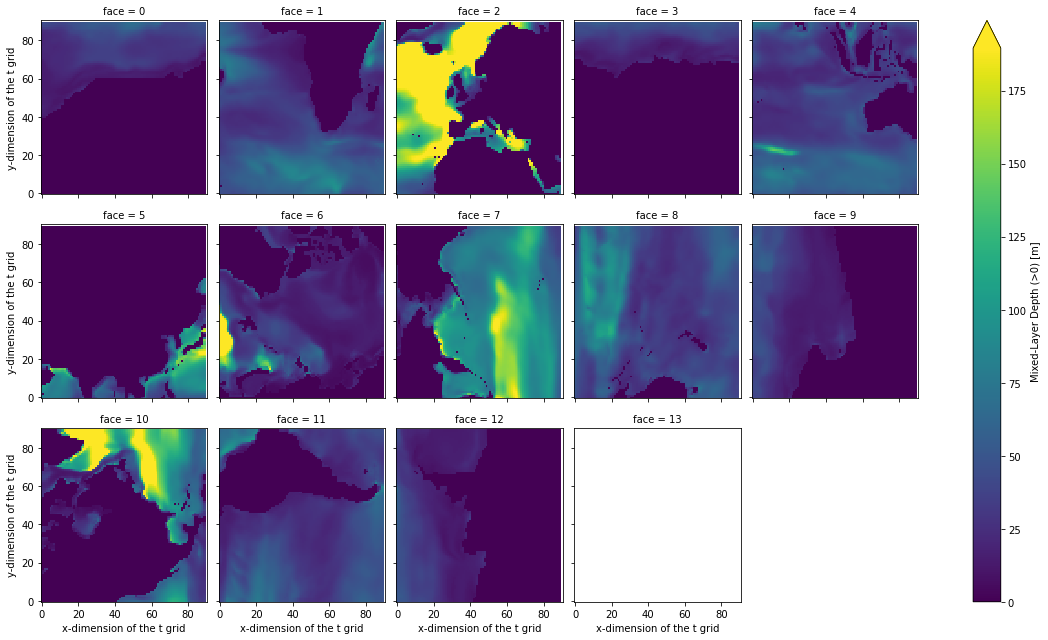

In [84]:
ds['MXLDEPTH'].isel(time=0).plot(col='face', col_wrap=5, robust = True)

In [86]:
# define the connectivity between faces
face_connections = {'face':
                    {0: {'X':  ((12, 'Y', False), (3, 'X', False)),
                         'Y':  (None,             (1, 'Y', False))},
                     1: {'X':  ((11, 'Y', False), (4, 'X', False)),
                         'Y':  ((0, 'Y', False),  (2, 'Y', False))},
                     2: {'X':  ((10, 'Y', False), (5, 'X', False)),
                         'Y':  ((1, 'Y', False),  (6, 'X', False))},
                     3: {'X':  ((0, 'X', False),  (9, 'Y', False)),
                         'Y':  (None,             (4, 'Y', False))},
                     4: {'X':  ((1, 'X', False),  (8, 'Y', False)),
                         'Y':  ((3, 'Y', False),  (5, 'Y', False))},
                     5: {'X':  ((2, 'X', False),  (7, 'Y', False)),
                         'Y':  ((4, 'Y', False),  (6, 'Y', False))},
                     6: {'X':  ((2, 'Y', False),  (7, 'X', False)),
                         'Y':  ((5, 'Y', False),  (10, 'X', False))},
                     7: {'X':  ((6, 'X', False),  (8, 'X', False)),
                         'Y':  ((5, 'X', False),  (10, 'Y', False))},
                     8: {'X':  ((7, 'X', False),  (9, 'X', False)),
                         'Y':  ((4, 'X', False),  (11, 'Y', False))},
                     9: {'X':  ((8, 'X', False),  None),
                         'Y':  ((3, 'X', False),  (12, 'Y', False))},
                     10: {'X': ((6, 'Y', False),  (11, 'X', False)),
                          'Y': ((7, 'Y', False),  (2, 'X', False))},
                     11: {'X': ((10, 'X', False), (12, 'X', False)),
                          'Y': ((8, 'Y', False),  (1, 'X', False))},
                     12: {'X': ((11, 'X', False), None),
                          'Y': ((9, 'Y', False),  (0, 'X', False))}}}

ds['DRW'] = ds.hFacW * ds.DRF #vertical cell size at u point
ds['DRS'] = ds.hFacS * ds.DRF #vertical cell size at v point
ds['DRC'] = ds.hFacC * ds.DRF #vertical cell size at tracer point

metrics = {
    ('X',): ['DXC', 'DXG'], # X distances
    ('Y',): ['DYC', 'DYG'], # Y distances
    ('Z',): ['DRW', 'DRS', 'DRC'], # Z distances
    ('X', 'Y'): ['RAC', 'RAZ', 'RC', 'RF'] # Areas
}

# create the grid object
xgrid = Grid(ds, periodic=False, face_connections=face_connections, metrics=metrics)
xgrid

KeyError: "Metric axes frozenset({'Z'}) not compatible with grid axes ('X', 'Y', 'T')"

In [45]:
# Calculate gradients in field
dg = xgrid.diff(ds['oceQsw'], 'X')
#gxg = xgrid.interp(dg ,'X')
# dgdx = xgrid.diff(gxg, 'X')

KeyError: 'oceQsw'

In [46]:
dg

,Array,Chunk
Bytes,131.41 MB,32.04 kB
Shape,"(312, 13, 90, 90)","(1, 1, 90, 89)"
Count,59280 Tasks,8112 Chunks
Type,float32,numpy.ndarray


In [47]:
gxg = xgrid.interp(dg ,'Y', boundary = 'fill')

ValueError: 'i' not found in array dimensions ('time', 'face', 'j', 'i_g')